In [9]:
import polars as pl
from polars import col as c
import plotnine as pln

pl_pokemon = (
    pl.read_csv(
        source = "data/pokemon.csv",
        schema_overrides = {
            "Type 1": pl.Categorical,
            "Type 2": pl.Categorical,
            "Generation": pl.Categorical,
            "Legendary": pl.Boolean
        }
    )
    .drop("#")
    .rename(lambda col: col.strip().replace(" ", "_").replace(".", ""))
    .with_columns(Generation = c("Generation").cast(pl.Utf8).cast(pl.Enum(["1", "2", "3", "4", "5", "6"])))
)

In [10]:
pl_pokemon.head(5)

Name,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,Legendary
str,cat,cat,i64,i64,i64,i64,i64,i64,i64,enum,bool
"""Bulbasaur""","""Grass""","""Poison""",318,45,49,49,65,65,45,"""1""",false
"""Ivysaur""","""Grass""","""Poison""",405,60,62,63,80,80,60,"""1""",false
"""Venusaur""","""Grass""","""Poison""",525,80,82,83,100,100,80,"""1""",false
"""VenusaurMega Venusaur""","""Grass""","""Poison""",625,80,100,123,122,120,80,"""1""",false
"""Charmander""","""Fire""",null,309,39,52,43,60,50,65,"""1""",false


# <span style="color:brown;">Two independent samples test</span>

In [4]:
from scipy import stats

In [6]:
(
    pl_pokemon
    .filter(c('Legendary') == True)
    .pipe(lambda f: stats.shapiro(f['Attack']))
)

ShapiroResult(statistic=np.float64(0.9607938487630754), pvalue=np.float64(0.03771789634848271))

In [7]:
(
    pl_pokemon
    .filter(c('Legendary') == False)
    .pipe(lambda f: stats.shapiro(f['Attack']))
)

ShapiroResult(statistic=np.float64(0.9808355320365648), pvalue=np.float64(3.1843612080590274e-08))

In [8]:
stats.mannwhitneyu(
    x = pl_pokemon.filter(c('Legendary') == True).get_column('Attack'),
    y = pl_pokemon.filter(c('Legendary') == False).get_column('Attack')
)

MannwhitneyuResult(statistic=np.float64(39868.0), pvalue=np.float64(3.4625666210159153e-19))

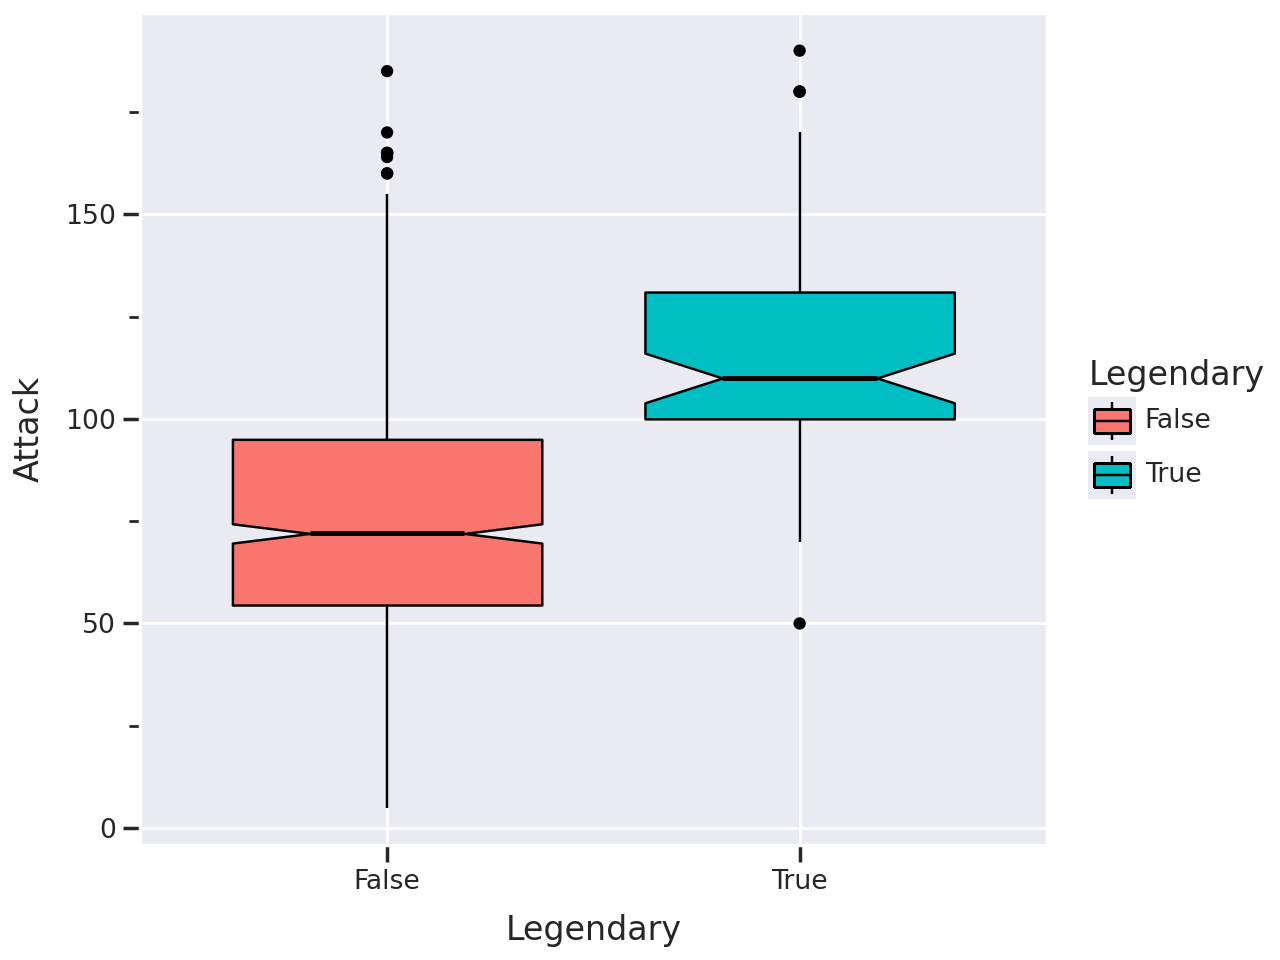

In [12]:
(
    pln.ggplot(data = pl_pokemon)
    + pln.theme_seaborn(style='darkgrid')
    + pln.geom_boxplot(
        mapping = pln.aes(x = 'Legendary', y = 'Attack', fill = 'Legendary'),
        notch = True,
        color = 'black'
    )
)

# <span style="color:brown;">Chi2 test for categorical variables</span>

In [20]:
lgnd_gen_table = (
    pl_pokemon
    .group_by(['Legendary', 'Generation'])
    .agg(Count = pl.len())
    .pivot(index = 'Legendary', on = 'Generation', values = 'Count')
)

print(lgnd_gen_table)

shape: (2, 7)
┌───────────┬─────┬─────┬─────┬─────┬─────┬─────┐
│ Legendary ┆ 1   ┆ 2   ┆ 3   ┆ 6   ┆ 5   ┆ 4   │
│ ---       ┆ --- ┆ --- ┆ --- ┆ --- ┆ --- ┆ --- │
│ bool      ┆ u32 ┆ u32 ┆ u32 ┆ u32 ┆ u32 ┆ u32 │
╞═══════════╪═════╪═════╪═════╪═════╪═════╪═════╡
│ true      ┆ 6   ┆ 5   ┆ 18  ┆ 8   ┆ 15  ┆ 13  │
│ false     ┆ 160 ┆ 101 ┆ 142 ┆ 74  ┆ 150 ┆ 108 │
└───────────┴─────┴─────┴─────┴─────┴─────┴─────┘


In [24]:
chi2, p_value, dof, expected_freq = stats.chi2_contingency(lgnd_gen_table)

print(f'Chi2 statistics: {chi2}\n')
print(f'P_value: {p_value}')

Chi2 statistics: 20.901731946194587

P_value: 0.0019107013484212219
